# Table of Contents

* [1. Gather the data](#1.-Gather-the-data)

* [2. Assess the data](#2.-Assess-the-data)

* [3. Clean the data](#3.-Clean-the-data)

* [4. Analyse the data](#4.-Analyse-the-data)

* [5. Modeling the Nutri-score](#5.-Modeling-the-Nutri-score)

* [6. Conclusion](#6.-Conclusion)

In [1]:
%matplotlib inline
import urllib.request
import time, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import zipfile
import re
import pycountry
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from glob import glob

In [2]:
pd.options.display.max_rows = 100

# 1. Gather the data

The following commands will download the necessary external data files dependencies
* OpenFoodFacts from https://world.openfoodfacts.org/data
* Geopandas maps from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/
* Worldbank life expectancy from https://data.worldbank.org/indicator/sp.dyn.le00.in


In [3]:
def reporthook(count, block_size, total_size):
    """Hook for urllib.request.urlretrieve() that provides visual help to confirm the current status of a file download
    
    Arguments:
        count: current chunk of data being read from the file
        block_size: size in byte of a single data chunk
        total_size: full size of the file to be downloaded
        
    Returns:
        Nothing
    """
    global start_time
    global counter
    if count == 0:
        start_time = time.time()
        counter = 0
        return
    counter = counter+1
    if counter < 100:
        counter = counter+1
        return
    counter = 0
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

In [4]:
# OpenFoodFacts dataset
url = 'https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv'
filename = 'openfoodfacts.csv'
urllib.request.urlretrieve(url, filename, reporthook)

...99%, 1965 MB, 9231 KB/s, 218 seconds passed

('openfoodfacts.csv', <http.client.HTTPMessage at 0x7f908c444c90>)

In [5]:
# Geopandas country maps
url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries_lakes.zip'
filename = 'ne_10m_admin_0_countries_lakes.zip'
urllib.request.urlretrieve(url, filename, reporthook)

...98%, 4 MB, 2752 KB/s, 1 seconds passed

('ne_10m_admin_0_countries_lakes.zip',
 <http.client.HTTPMessage at 0x7f905cafdb10>)

In [6]:
# extract the country data
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('countries')
    
# remove the zip file
os.remove(filename)

In [7]:
# Worldbank life expectancy (at birth) per country
url = 'http://api.worldbank.org/v2/en/indicator/SP.DYN.LE00.IN?downloadformat=csv'
filename = 'SP.DYN.LE00.IN.zip'
urllib.request.urlretrieve(url, filename, reporthook)

('SP.DYN.LE00.IN.zip', <http.client.HTTPMessage at 0x7f905cb080d0>)

In [8]:
# extract the worldbank data
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('worldbank')
    
# remove the zip file
os.remove(filename)

# 2. Assess the data

## 2.1 Assess the OpenFoodFacts data

The OpenFoodFacts team have published a small help to understand the fields available in the dopenfoodfacts.csv dataset. The description is available from https://static.openfoodfacts.org/data/data-fields.txt.

### Load the data

In [9]:
# load the dataset
df = pd.read_csv('openfoodfacts.csv', sep='\t', low_memory=False)

# identify the shape of the data
print("dataset shape: ", df.shape)

# display the first few rows
df.head()

dataset shape:  (999503, 175)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Identify missing values

In [10]:
# identify the missing values
df.isnull().mean()

code                  0.000000
url                   0.000000
creator               0.000003
created_t             0.000000
created_datetime      0.000001
                        ...   
choline_100g          0.999970
phylloquinone_100g    0.999997
beta-glucan_100g      0.999980
inositol_100g         0.999963
carnitine_100g        0.999985
Length: 175, dtype: float64

The dataset has disparate features in terms of missing values ratio. Some columns have absolutely no missing value, while others are close to having 99% of missing values. We will however not remove the nutrients columns even if they have a lot of missing data, as we want to use this information to identify the health value of each product.

### Isolate the nutrients columns

According to the openfoodfacts data description [here](https://static.openfoodfacts.org/data/data-fields.txt), there are a large number of nutrients columns. We will want to build a list of the columns containing this kind of information since we will want to isolate them for further analysis.

In [11]:
def get_nutrients(df):
    """Identified in the dataframe the columns that contain '100g' in their name and assume they represent nutrients. Exclude specific non-nutrient columns
    
    Arguments:
        df: dataframe with nutrient columns among others
        
    Returns:
        list of names for the assumed nutrients columns
    """
    # extract the list of columns containing nutrients (information per 100g)
    nutrients = []
    for col in df.columns:
        if '100g' in col:
            nutrients.append(col)

    # remove the 'energy', 'nutrition', 'carbon-footprint' columns as they are not representing directly nutrients
    for col in nutrients.copy():
        if ('energy' in col) | ('nutrition' in col) | ('carbon-footprint' in col):
            nutrients.remove(col)
            
    return nutrients

In [12]:
# identify nutrients available in the dataframe
nutrients=get_nutrients(df)

# show the number of nutrients identified 
print("number of nutrients identified: ", len(nutrients))

# show the first few rows
list(nutrients)[0:10]

number of nutrients identified:  101


['fat_100g',
 'saturated-fat_100g',
 '-butyric-acid_100g',
 '-caproic-acid_100g',
 '-caprylic-acid_100g',
 '-capric-acid_100g',
 '-lauric-acid_100g',
 '-myristic-acid_100g',
 '-palmitic-acid_100g',
 '-stearic-acid_100g']

## 2.2 Assess the Worldbank data

### Load the data

In [13]:
# load the life expectancy dataset
filename = glob('worldbank/API_SP.DYN.LE00.IN_DS2*.csv')[0]
full_expect_df = pd.read_csv(filename, skiprows=3)

# print information about the loaded data
print("dataset shape: ", full_expect_df.shape)

# show the first few rows
full_expect_df.head()

dataset shape:  (264, 64)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,65.662,66.074,66.444,66.787,67.113,67.435,...,75.017,75.158,75.299,75.441,75.583,75.725,75.868,76.010,NaN,NaN
1,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,32.446,32.962,33.471,33.971,34.463,34.948,...,61.028,61.553,62.054,62.525,62.966,63.377,63.763,64.130,NaN,NaN
2,Angola,AGO,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,37.524,37.811,38.113,38.430,38.760,39.102,...,55.350,56.330,57.236,58.054,58.776,59.398,59.925,60.379,NaN,NaN
3,Albania,ALB,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,62.283,63.301,64.190,64.914,65.463,65.850,...,76.562,76.914,77.252,77.554,77.813,78.025,78.194,78.333,NaN,NaN
4,Andorra,AND,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# find the most recent year with life expectancy data
full_expect_df.dropna(how='all', axis=1).columns[-5:]

Index(['2013', '2014', '2015', '2016', '2017'], dtype='object')

In [15]:
# find the most recent year with life expectancy data (not too many missing values)
full_expect_df.isnull().mean().reindex(['2015','2016','2017','2018','2019'])

2015    0.068182
2016    0.071970
2017    0.071970
2018    1.000000
2019         NaN
dtype: float64

From this data it seems the latest year with suitable data is 2017, since in 2018 all data is missing, and the 2019 data column is not available at all. The rest of the analysis will use the data from 2017 as reference.

In [16]:
# confirm there is only one indicator in the whole file
full_expect_df.groupby('Indicator Name')['Indicator Name'].count()

Indicator Name
Life expectancy at birth, total (years)    264
Name: Indicator Name, dtype: int64

The file only has the "Life expectancy at birth, total (years)" indicator, so there is no need for special processing to isolate only this indicator

In [17]:
# construct the life expectancy dataframe for the data of 2017. This will serve as a reference for the later analysis.
expect_df = full_expect_df[['Country Code','Indicator Name','2017']]

# remove any rows with missing values
expect_df = expect_df.dropna()

# show a subset of the data
expect_df

,Country Code,Indicator Name,2017
0,ABW,"Life expectancy at birth, total (years)",76.010000
1,AFG,"Life expectancy at birth, total (years)",64.130000
2,AGO,"Life expectancy at birth, total (years)",60.379000
3,ALB,"Life expectancy at birth, total (years)",78.333000
5,ARB,"Life expectancy at birth, total (years)",71.622526
...,...,...,...
259,XKX,"Life expectancy at birth, total (years)",71.946341
260,YEM,"Life expectancy at birth, total (years)",66.086000
261,ZAF,"Life expectancy at birth, total (years)",63.538000
262,ZMB,"Life expectancy at birth, total (years)",63.043000


# 3. Clean the data

## 3.1 Clean the openfoodfacts data

In this section we are dropping the columns that only contain only missing values. These features will not provide any useful information for further data analysis.

In [18]:
df = df.dropna(how="all", axis=1)

We are also dropping the columns referring to external URLs that will not be useful for our project. In the rest of the notebook, we will be only looking at numeric information such as the level of nutrients, or categorical information such as the countries where products are sold.

In [19]:
# identify the columns to drop through regular expression matching
to_drop = list(filter((lambda x: re.match(r'image_', x)), df.columns))

# add one more column we want to drop
to_drop.append('url')

# display operation and execute it
print("dropping URL columns: ", to_drop)
df = df.drop(to_drop, axis=1)

# display the resulting shape so we can compare impact of the data reduction
print("dataset shape: ", df.shape)

dropping URL columns:  ['image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'url']
dataset shape:  (999503, 154)


In [20]:
# recalculate the list of nutrients remaining after the data cleaning
nutrients=get_nutrients(df)

# show the number of nutrients identified 
print("number of nutrients identified: ", len(nutrients))

number of nutrients identified:  92


In [21]:
# display the first few rows
df.head()

,code,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000001111111111,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000123,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000178,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to keep only data where nutrient information is available, we will clean the dataset from all rows without missing or outlier data for these columns

In [22]:
# remove products where nutrients information is not provided
zero_sum = df.loc[:,nutrients].sum(axis=1)==0
no_nutrients = df[zero_sum].index
df = df.drop(no_nutrients)

# remove products where nutrients information is an outlier
too_small = df.loc[:,nutrients].sum(axis=1) < 1
too_large =  df.loc[:,nutrients].sum(axis=1) > 1000
outlier_nutrients = df[too_small | too_large].index
df = df.drop(outlier_nutrients)

# show the resulting data shape
print("dataset shape: ", df.shape)

# show the first few rows
df.head()

dataset shape:  (788325, 154)


,code,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000123,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000178,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0000000000949,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,Salade de carottes râpées,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
9,0000000000970,kiliweb,1520506368,2018-03-08T10:52:48Z,1561463726,2019-06-25T11:55:26Z,Fromage blanc aux myrtilles,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Mapping the countries tags to ISO3 codes

The dataset contains country information, however the format is not suitable for data analysis.
There are multiple columns with country information: 

* `countries`
* `countries_tags`
* `countries_en`

The first step is to build a list of countries. We will be using the `countries_tags` columns for processing as it is the most standardised column. We are removing the prefix from the country names. As the `countries_tags` cell can contain multiple countries, we will split the values to list all individual countries present in the dataset. We are converting the data to a set to ensure uniqueness of country names.

In [23]:
# identify ratio of missing values for the country name
df['countries_tags'].isnull().mean()

0.0008499032759331494

The ratio of missing country information is less than 0.1%. This field looks to be very useful as it is present in almost all product descriptions.

In [24]:
# assess the number of different countries present in the dataset
countries = []
for val in df.countries_tags:
    try:
        lst = list(map(lambda s: s.split(':')[-1], val.split(',')))
        countries.extend(lst)
    except AttributeError:
        pass

# use a set to ensure uniqueness of country identification
countries = set(countries)
print("The number of distinct countries is {}.".format(len(countries)))

The number of distinct countries is 248.


Display a sample of the countries names

In [25]:
list(countries)[0:20]

['greece',
 'germany',
 'mexico',
 'jordan',
 'nepal',
 'lithuania',
 'export',
 'kosovo',
 'jersey',
 'isle-of-man',
 'svájc',
 'syria',
 'bulgaria',
 'nl-be',
 'fiji',
 'montenegro',
 'christmas-island',
 'belgium',
 'finland',
 'românia-republica-moldova']

Build a lookup dictionary with all these countries as well as a summary list of the resulting ISO3 codes (excluding possible NaN value)

In [26]:
def country_code(text):
    """Looks up a country name in the pycountry database and returns the ISO3 code for that country
    
    Arguments:
        text: the name of a country to look up in the pycountry database
    
    Returns:
        the corresponding ISO3 code for the country, or NaN if not found
    """
    try:
        search_text = text.replace('-',' ')
        if len(search_text) > 2:
            code = pycountry.countries.search_fuzzy(search_text)[0].alpha_3
        else:
            code = np.nan
    except LookupError:
        code = np.nan
    return code

In [27]:
# lookup the ISO3 code for every valid country identified in the previous step and build a dictionary for future use 
country_lookup = { country:country_code(country) for country in countries if str(country_code(country)) != 'nan' }
country_ISO3 = list(set(country_lookup.values()))
print ("The number of unique ISO3 codes is ", len(country_ISO3))

The number of unique ISO3 codes is  179


We now expand the countries information in the original openfoodfacts dataset to a series of features, one per country.
The result will be a large number of new columns, similar to a one hot encoding result where the value 1 indicates the product is sold in that country.

Since there is a possibility that multiple country "names" in the `countries_tags` column map to the same country ISO code,
we will be summing the identified country mapping results and not just setting the value at each iteration, otherwise counts would be overwritten
and information would be missing.

In [28]:
# Function to split and return values for columns
def split_countries(tag, country):
    """Identifies if the list of tags contain a specific country name. If that is the case, return a value 1.
    
    Arguments:
        tag: a string representing one or multiple tags to search for a specific country tag
        country: a string representing the country tag being looked up
        
    Returns
        1 if the country was found in the tag string
        0 otherwise
    """
    try:
        if tag.find(country)>-1:
            return 1
        else:
            return 0
    except AttributeError:
        return 0

In [29]:
# prepare an empty dataframe with the correct dimensions, and initialised to 0 values
df_countries = pd.DataFrame(0, index=df.index, columns=country_ISO3)

# Apply function for each country
for curr_country in countries:
    curr_ISO3 = country_lookup[curr_country] if curr_country in country_lookup else np.nan
    if str(curr_ISO3) != 'nan':
        df_countries[curr_ISO3] += df['countries_tags'].apply(lambda tag: split_countries(tag, curr_country))

In [30]:
# assess how many rows had a country we could map to an ISO3 code
has_country = df_countries[df_countries.sum(axis=1)>0]
total = df.shape[0]
total_mapped = has_country.shape[0]

print("total number of rows in data: ", total)
print("total number of rows with mapped country: ", total_mapped)
print("ratio of rows with a mapped country: ", total_mapped/total)

total number of rows in data:  788325
total number of rows with mapped country:  787494
ratio of rows with a mapped country:  0.9989458662353725


The mapping from the country tag into one or multiple countries was successful at 99.8% which shows that we can trust the resulting country information

In [31]:
# merge the country columns back into the main dataframe
df = pd.concat([df, df_countries], axis=1)

# show the first few rows
df.head()

,code,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,LBN,KEN,VNM,JEY,NLD,IRN,IRQ,GNQ,CUB,IND
0,0000000000017,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,0000000000123,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0000000000178,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
8,0000000000949,kiliweb,1523440813,2018-04-11T10:00:13Z,1565268412,2019-08-08T12:46:52Z,Salade de carottes râpées,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9,0000000000970,kiliweb,1520506368,2018-03-08T10:52:48Z,1561463726,2019-06-25T11:55:26Z,Fromage blanc aux myrtilles,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


### Counting the usage of countries in the openfoodfacts dataset

In [32]:
def summarise_countries(df, country_columns=country_ISO3):
    """Takes a dataframe with a column for each country feature and transforms it into a total count of elements for each country
    
    Arguments:
        df: dataframe having a column for each country and value 1 or 0 based on product being sold in that country or not
        country_columns: list of the column names to isolate for the processing.
                         this allows to call this function with a dataframe that contains extra columns that will then be ignored.
                         
    Returns:
        dataframe with the count of occurences and log10 count of occurences of each country
    """
    # build a summary of the countries associated with each product
    country_count = df[country_columns].sum().sort_values(ascending=False)
    country_count = pd.DataFrame(country_count, columns=['count'])

    # since the disparity of data available per country is quite large, we also want to add the log10 to the dataframe
    country_count['log_count']=np.log10(country_count['count'])

    # remove empty values
    country_count = country_count.drop(country_count[country_count['count'] == 0].index)

    # transform the country ISO3 code index into a column of its own
    country_count = country_count.reset_index().rename(columns={'index': 'country'})

    return country_count

In [33]:
# execute the country summarisation on the dataframe
df_country_count = summarise_countries(df)

# provide a sample of the counts and log10 counts of usage for each country
df_country_count

,country,count,log_count
0,FRA,487152,5.687664
1,USA,170675,5.232170
2,ESP,55634,4.745340
3,CHE,28685,4.457655
4,BEL,27208,4.434697
...,...,...,...
174,MDV,1,0.000000
175,IMN,1,0.000000
176,PNG,1,0.000000
177,IOT,1,0.000000


# 4. Analyse the data

## 4.1 Geographical analysis: "What countries does the OpenFoodFacts data cover?"

In this section, we will present countries from openfoodfact data on a world map.

Visualisation code inspired from: https://ramiro.org/notebook/geopandas-choropleth/

In [34]:
def geodata(shapefile='countries/ne_10m_admin_0_countries_lakes.shp'):
    """Loads the geopandas world map model from the downloaded shape files
    
    Arguments:
        shapefile: location to the geopandas shape file set (will use multiple files from the same folder)
        
    Returns:
        geopandas world map model
    """
    return gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')

In [35]:
# build the standard geopandas dataframe
gdf = geodata()

In [36]:
def geomapping(gdf, df, column='country', exclude=['ATA']):
    """Merges the standard world map model with a dataset to present based on country information
    
    Arguments:
        gdf: the standard geopandas world map model
        df: the dataset containing data to present visually on the world map
        column: name of the column to tie a country in the df dataframe to the actual geographical country on the map
        exclude: list of the ISO3 codes of the countries that should not be represented on the map
    
    Returns:
        a merged geopandas world map model expanded to also contain the data from the df dataset
    """
    # merge the world data with the dataframe of openfoodfacts data
    merged = gdf.merge(df, left_on='ADM0_A3', right_on=column, how='left')
    
    # replace any NaN value with zeroes
    merged = merged.fillna(0)
    
    # drop countries that we want to exclude from the result
    merged = merged.drop(merged[merged['ADM0_A3'].isin(exclude)].index)
    
    return merged

In [37]:
def plot_map(df, title, description='', column='count', figsize=(16,10)):
    """Produces the display of the world map and colorising each country based on the value stored in the dataframe
    
    Arguments:
        df: geopandas world model including the extra columns from the dataframe to define the color of each country
        title: title to be displayed in the top left of the diagram
        description: text to be displayed at the bottom of the diagram
        column: name of the column containing the value that will drive the intensity of the colouring for the country
        figsize: matplotlib figsize parameter to drive the size of the visual
        
    Returns:
        nothing
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    ax = df.dropna().plot(column=column, cmap='GnBu', figsize=figsize, legend=True, ax=ax, cax=cax, edgecolor='black', linewidth=0.1)

    ax.set_title(title, fontdict={'fontsize': 15}, loc='left')
    ax.annotate(description, xy=(0.1, 0.1), size=12, xycoords='figure fraction')

    ax.set_axis_off()
    ax.set_xlim([-1.5e7, 1.7e7])

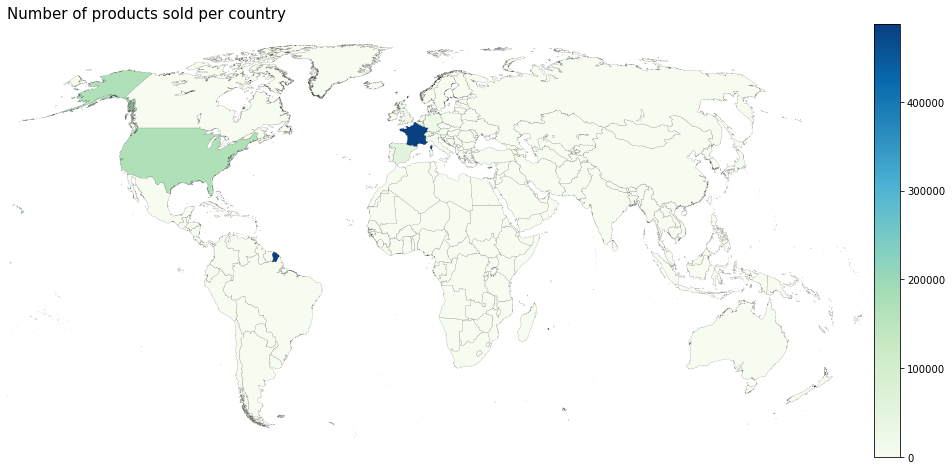

In [38]:
# builds a map model that is merged with the df_country_count data that holds total count of products per country
mapdata = geomapping (gdf, df_country_count)

# builds a map showing the total number of products sold per country
plot_map(mapdata, 'Number of products sold per country', column='count')

This world map shows only a very strong colouring for France. There is a much lighter colouring for the USA and a few other countries. 
The rest of the world has such a low number of products listed in the openfoodfacts dataset that the linear scale selected here is not able to build a visual understanding of which countries are represented in the dataset.

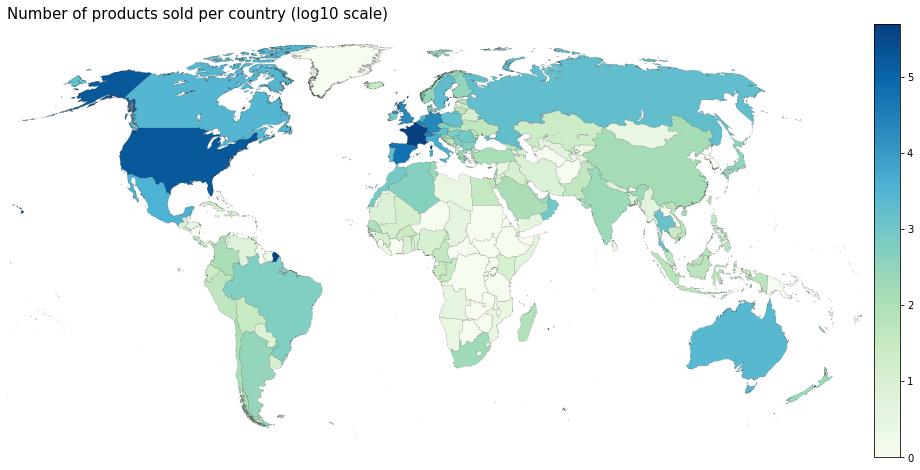

In [39]:
# builds a map showing the total number of products sold per country
plot_map(mapdata, 'Number of products sold per country (log10 scale)', column='log_count')

With a logarithmic scale it is much easier to visualise the list of countries with products listed in the openfoodfacts dataset. Many regions of the world are covered, however with a lower level of magnitude than the French products data.

## 4.2 Nutri-score geographical analysis: "Which countries can we analyse with the Nutri-score classification information?"


In this section we will be analysing the Nutri-score information present in the openfoodfacts dataset.

The Nutri-score is a nutrition label that was selected by the French government in March 2017 to be displayed on food products. A Nutri-score for a particular food item is given in one of five classification letters, with 'A' being a preferable score and 'E' being a detrimental score.

For more information, see https://en.wikipedia.org/wiki/Nutri-score

In [40]:
# identify ratio of missing values for the nutri-score feature
df['nutrition_grade_fr'].isnull().mean()

0.6420067865410839

The ratio of missing nutri-score information is about 64%. We could expect that not all rows would have this indication since the nutri-score is not present in all countries.

In [41]:
# build a dataframe with only the rows with a nutriscore
nutri_df = df[df['nutrition_grade_fr'].isnull() == False]
nutri_df.shape

(282215, 333)

The fact only 282K rows contain the nutriscore means that not all products sold in France (about 487K rows) have this information in our dataset.

We still have enough material for doing an initial analysis, and we will be trying to fill-in the gaps of missing nutri-score ratings through machine learning technique.

Next, we will show on a map the countries having a nutri-score available in the base data to confirm our assumption this is only available mostly for products sold in France.

Note that since a same product sold in multiple countries is materialsed with a single row in the openfoodfacts dataset, a product sold in France along other countries may be showing a nutri-score when associated with the other countries, as a side effect.

In [43]:
# execute the country summarisation on the dataframe
df_nutri_count = summarise_countries(nutri_df)

# provide a sample of the counts and log10 counts of usage for each country
df_nutri_count

,country,count,log_count
0,FRA,206267,5.314430
1,ESP,27938,4.446195
2,USA,22965,4.361066
3,DEU,16197,4.209435
4,CHE,10404,4.017200
...,...,...,...
145,LBY,1,0.000000
146,TGO,1,0.000000
147,LIE,1,0.000000
148,MWI,1,0.000000


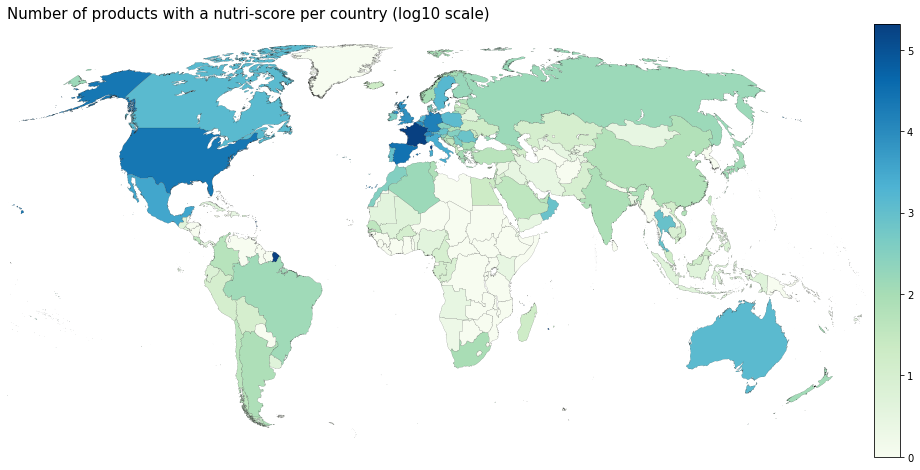

In [44]:
# builds a map model that is merged with the df_nutri_count data that holds total count of products with a nutri-score per country
mapdata = geomapping (gdf, df_nutri_count)

# builds a map showing the total number of products with a nutri-score per country
plot_map(mapdata, 'Number of products with a nutri-score per country (log10 scale)', column='log_count')

Clearly, again the data is very centered around France. However the USA, Spain, other european countries have a nutri-score. However as discussed above, this could be a side-effect of the same product being sold in France along with these other countries wiho then "inherit" from the Nutri-score applied to the product also sold in France.

## 4.3 Nutri-score ranking analysis: "What is the Nutri-score distribution in all scored products?"

We will now identify the distribution of nutri-score ranking (from A to E) among products

In [45]:
# calculate the distribution of nutri-score per each category
distribution = nutri_df.groupby('nutrition_grade_fr').nutrition_grade_fr.count()

# show the distribution table
distribution

nutrition_grade_fr
a    40184
b    36793
c    61410
d    87369
e    56459
Name: nutrition_grade_fr, dtype: int64

In [46]:
# show the distribution as a ratio of the total
distribution / distribution.sum()

nutrition_grade_fr
a    0.142388
b    0.130372
c    0.217600
d    0.309583
e    0.200057
Name: nutrition_grade_fr, dtype: float64

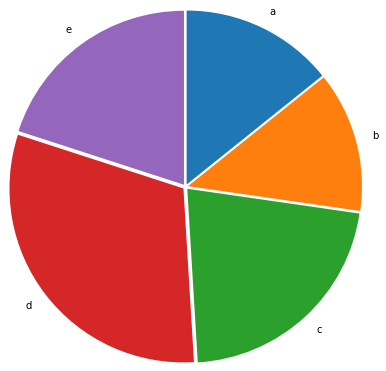

In [47]:
# show a pie chart of the distribution
plt.pie(distribution, labels=distribution.index, explode=[0.03]*len(distribution.index), radius=2, counterclock=False, startangle=-270);

We can see the data is skewed towars the 'd' nutri-score category which represents almost 31% of the products in the dataset.

In the next cells, we will show a random sample of 10 products classified in each of the nutri-score categories

In [48]:
def sample_products_per_nutriscore(df, random_state=42):
    """Prints a list of sample products for each of the 5 nutri-score categories
    
    Arguments:
        df: a dataframe with the  nutrition_grade_fr and product_name columns to select from
        random_state: random generator seed that allow reproductibility of the execution
        
    Returns:
        nothing
    """
    possible_scores = ['a','b','c','d','e']
    for score in possible_scores:
        print("sample of products with a nutri-score: ", score)
        filter1 = df['nutrition_grade_fr'] == score
        filter2 = df['product_name'].isnull() == False
        for product in df[filter1 & filter2]['product_name'].sample(10, random_state=random_state):
            print('-', product)
        print("")

In [49]:
# show a sample of products classified in each nutri-score category
sample_products_per_nutriscore(nutri_df)

sample of products with a nutri-score:  a
- Rucola
- Céleri-rave râpé
- Festonati
- Compote de pêche
- Fromage Blanc 2,8 de matière grasse
- QUAKER OATS
- Garofalo Integrale Radiatori 5-87 GR.500
- Compote de pommes bio
- Champignons de Paris pieds et morceaux
- Chicken Breasts

sample of products with a nutri-score:  b
- Légumes pour tajine
- 5 pitas
- Nori Sushi
- Yaourt Nature entier en pot paraffiné
- Yogurt Greco
- Piémontaise au thon
- Filet de poulet
- vegetarischer Gemüse Nudel Topf
- Blé soufflé au caramel
- Souris d'agneau confite

sample of products with a nutri-score:  c
- Yaourt saveur coco au lait entier
- Callos a la madrileña
- Ice Tea saveur Fruits rouges
- Soupe de pois cassés au lard savoyard
- Protein whipped bites fraise
- La Boule Brownie
- Bâtonnets de Surimi
- Filet de poulet rôti
- Pure classic jus d'orange
- Filets de maquereaux

sample of products with a nutri-score:  d
- Trio houmous
- Sauce barbecue
- Queso de cabra semicurado
- Dee Thai Huile De Sésame
- M

# 5. Modeling the Nutri-score

## 5.1 Machine-learning model: "Can we calculate the nutri-score with Machine Learning?"

We will now try to calculate the missing nutri-scores for the rest of the products. We will be developing a classifier model based on a Random Forest Classifier. This will be learning from a training set among the products having a nutri-score, and we will be confirming the accuracy of the classifier on a test set also from the labeled data.

Then we will be using the classifier to predict the nutri-score of products not classified in the source data.

In [50]:
# build a dataframe with only the rows with a nutriscore
# NOTE: this was already done earlier in the notebook, but reproducing here for clarity in the code
nutri_df = df[df['nutrition_grade_fr'].isnull() == False]

# show the shape of the dataframe
nutri_df.shape

(282215, 333)

In [51]:
# build a features dataframe and a label series from the input data
X = nutri_df.loc[:,nutrients]

# fill all NaN values with a 0 since the classifier is not running on missing values.
# In our business context a mssing value has the same meaning as a zero value, so this operation does not distort the data
X = X.fillna(0)
y = nutri_df['nutrition_grade_fr']

# separate the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will be creating a random forest classifier, and scoring its accuracy with a growing number of estimators to understand impact on accuracy. We expect to get a higher accuracy with more estimators.

In [52]:
score_train = []
score_test = []
estimators_range = np.arange(10,220,20)

# loop through a growing number of estimators to assess impact on accuracy
for n_estimators in estimators_range:
    clf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    s_train = clf.score(X_train, y_train)
    score_train.append(s_train)
    s_test = clf.score(X_test, y_test)
    score_test.append(s_test)
    print('fitting with n_estimators: ', n_estimators, ' score on train data: ', s_train, ' score on test data: ', s_test)

fitting with n_estimators:  10  score on train data:  0.9822874404266251  score on test data:  0.8809949860921638
fitting with n_estimators:  30  score on train data:  0.9866458196764878  score on test data:  0.8918023492727176
fitting with n_estimators:  50  score on train data:  0.9870267349361302  score on test data:  0.8940346898641107
fitting with n_estimators:  70  score on train data:  0.9871020321386177  score on test data:  0.8956823698244246
fitting with n_estimators:  90  score on train data:  0.9871286076218486  score on test data:  0.8962847474443244
fitting with n_estimators:  110  score on train data:  0.9871374661162589  score on test data:  0.8961430115337597
fitting with n_estimators:  130  score on train data:  0.987141895363464  score on test data:  0.8967985401201212
fitting with n_estimators:  150  score on train data:  0.987141895363464  score on test data:  0.8969048420530447
fitting with n_estimators:  170  score on train data:  0.987141895363464  score on test

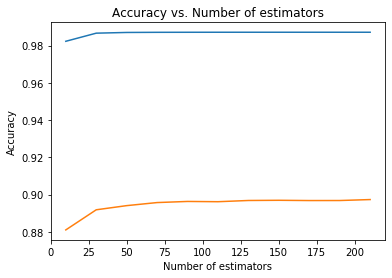

In [53]:
# show the growth of accuracy based on the number of estimators.
# the chart shows the score on training data (line at the top) and on testing data (line at the bottom)
# note the X axis does not start at zero, so though the testing data line is at the "bottom" of the chart, the score is still quite high
plt.plot(estimators_range, score_train);
plt.plot(estimators_range, score_test);
plt.xlabel('Number of estimators');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of estimators');

We can see there is no need to run the classified with a very high number of estimators, the accuracy is showing extremely slow improvement past 100 estimators.

In [54]:
# create a random forest classifier with a selected parameter of 100 estimators
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42, n_jobs=-1)

In [55]:
# fit the model with the training data
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
# score the model
print("classifier score on training data: ", clf.score(X_train, y_train))
print("classifier score on testing data: ", clf.score(X_test, y_test))

classifier score on training data:  0.9871374661162589
classifier score on testing data:  0.896550502276633


A score of 89.6% is quite good, even if we see the classifier has a tendency to overfit based on the difference between the score on training data vs. the score on testing data.

In [57]:
# calculating the confusion matrix for the test set
y_pred = clf.predict(X_test)
labels = ['a','b','c','d','e']
mat = confusion_matrix(y_test, y_pred, labels=labels)
mat

array([[ 7304,   385,   210,    26,    79],
       [  482,  6077,   570,   117,   134],
       [  138,   395, 10853,   713,   247],
       [   62,    97,   648, 16272,   432],
       [  116,   134,   253,   601, 10098]])

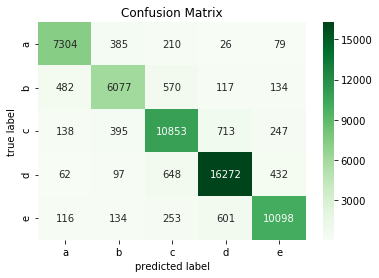

In [58]:
# presenting the confusion matrix in a graphical way
df_cm = pd.DataFrame(mat, labels, labels)
ax=sns.heatmap(df_cm, annot=True, fmt='g', cmap='Greens');
ax.set_title('Confusion Matrix');
ax.set_ylabel('true label');
ax.set_xlabel('predicted label');
ax.set_ylim(df_cm.shape[0], 0);   # display is affected by bug:  https://github.com/matplotlib/matplotlib/issues/15179

The confusion matrix shows that when there are errors in the classification, most classification errors are with adjacent score. For example a label of 'd' is mostly confused with 'c' or 'e', not significantly with 'a' or 'b'. The later analysis of the data will therefore try to bundle up categories 'a' and 'b' and identify them as "desirable products", and categories 'c' and 'd' and identify them as "undersirable products"

We can now predict the nutri-score of the products not yet classified using our model

In [59]:
# build a dataframe with only the rows without a nutri-score
unclassified_df = df[df['nutrition_grade_fr'].isnull() == True]

# show the shape information of the resulting dataframe
unclassified_df.shape

(506110, 333)

In [61]:
# keep only nutrients columns for the prediction data input
X_pred = unclassified_df.loc[:,nutrients]

# fill all NaN values with a 0 since the classifier is not running on missing values.
# In our business context a mssing value has the same meaning as a zero value, so this operation does not distort the data
X_pred = X_pred.fillna(0)

# show the shape of the resulting dataframe
X_pred.shape

(506110, 92)

In [62]:
# run the model to calculate the predicted values
y_pred = clf.predict(X_pred)

# show the shape of the result
y_pred.shape

(506110,)

In [64]:
# integrate the predicted data back into our dataframe for "unclassified" data. Our dataframe now is enhanced with a nutri-score label
unclassified_df.loc[:,'nutrition_grade_fr'] = y_pred

# save this dataframe in a new variable name to show the change in the data
inferred_df = unclassified_df

In [65]:
# calculate the distribution of nutri-score per each category
distribution = inferred_df.groupby('nutrition_grade_fr').nutrition_grade_fr.count()

# show the distribution table
distribution

nutrition_grade_fr
a     67058
b     61211
c    108913
d    166567
e    102361
Name: nutrition_grade_fr, dtype: int64

In [66]:
# show the distribution as a ratio of the total
distribution / distribution.sum()

nutrition_grade_fr
a    0.132497
b    0.120944
c    0.215196
d    0.329112
e    0.202250
Name: nutrition_grade_fr, dtype: float64

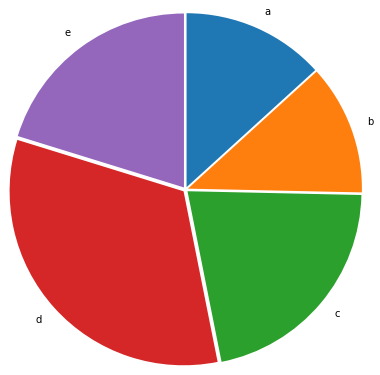

In [67]:
# show a pie chart of the distribution
plt.pie(distribution, labels=distribution.index, explode=[0.03]*len(distribution.index), radius=2, counterclock=False, startangle=-270);

The distribution of the nutri-scores determined through the random forest classifier is very similar to the originally labeled data.

we will show a random sample of 10 products classified in each of the nutri-score categories for the inferred data

In [68]:
# show a sample of products classified in each nutri-score category
sample_products_per_nutriscore(inferred_df)

sample of products with a nutri-score:  a
- Shiitake
- Filets de Flétan
- Organic Good Seed Rock 'N' Rolls
- Помидоры резаные
- Chobani fit
- Traditional Greek Nonfat Yogurt, Vanilla
- Lake Champlain Organic Hot Chocolate Mix
- Roquette
- Cinnamon Apple Sauce
- COMPOTE DE POMMES

sample of products with a nutri-score:  b
- Activia bifidus vanille
- Crêpes moelleuses au sucre de canne x 8
- Actuvia mix and go, amandes, quinoa, graines de chia
- Pollo Asado Troceado
- Singapore nodles
- Gratin coquillettes jambon
- Pâtes et mozzarella
- Caldo Verde
- frank juice
- Coulis fruit rouge

sample of products with a nutri-score:  c
- Zero calorie sauce
- Monse's Taste Of El Salvador, Zucchini & Sweet Corn Papusas
- Jus d'Orange Bio
- Salt
- Organic 100% Juice, Pineapple Orange Banana
- Muffin au chocolat
- Sea Salt Pita Crackers
- Grillades ail des ours
- Lentejas con Chorizo
- Whole Berry Cranberry Sauce

sample of products with a nutri-score:  d
- Whole Sweet Midgets
- Brown sugar and ginger 

## 5.2 Analysis of the combined data: "Do all countries have an equivalent Nutri-score distribution?"

We will now combine and analyse the originally labeled and inferred labeled dataset into a single dataframe to assess the nutri-score across the whole set of countries with data

In [69]:
# create a new dataframe with a combination of the nutri-score datasets
df_new = pd.concat([nutri_df, inferred_df], axis=0)

# show the shape of the combined dataframe
df_new.shape

(788325, 333)

Show the relative ratio of each nutri-score in each country where data is available

Code for the stacked chart inspired from https://pstblog.com/2016/10/04/stacked-charts

In [70]:
# build a data table with the usage of nutri-score for each country
nutri_per_country = df_new.groupby('nutrition_grade_fr').sum().sort_values(by='nutrition_grade_fr')

# restrict data to only the contry features, the rest is not useful for this analysis part
nutri_per_country = nutri_per_country[country_ISO3]

# show a sample of the result
nutri_per_country

,MLT,BDI,ARE,RWA,PAK,LKA,PRY,DZA,MAF,ESP,...,LBN,KEN,VNM,JEY,NLD,IRN,IRQ,GNQ,CUB,IND
nutrition_grade_fr,,,,,,,,,,,,,,,,,,,,,
a,9,0,32,0,17,0,1,78,0,7591,...,20,4,18,0,592,2,2,0,1,22
b,9,1,36,1,8,0,2,59,2,8766,...,11,3,8,2,428,1,2,0,1,24
c,12,0,39,1,7,1,2,98,0,12577,...,17,2,8,1,637,2,2,0,2,35
d,16,0,42,0,5,0,2,128,2,17736,...,44,2,14,0,861,2,1,1,3,63
e,10,0,43,0,6,2,1,121,1,8964,...,27,0,11,1,569,1,5,0,5,63


We will be calculating the distribution ratio of each nutri-score category for each country. In order not to rely on a single product or a too small number of products to come to that result, we will be applying an arbitrary filter of 30 products minimum to include a country in the calculation results.

In [71]:
# for the charting we actually need the nutri-score in the columns, so we transpose the data
nutri_per_country = nutri_per_country.transpose()

# calculate the total of products scored in each country
total_per_country = nutri_per_country.sum(axis=1)

# have a minimum of 30 products to have meaningful data
to_drop = total_per_country[total_per_country<=30].index

# drop the rows with not enough scores
total_per_country = total_per_country.drop(to_drop)

# build a dataframe with the percentage of each nutri-score per country
percent_per_country = nutri_per_country.div(total_per_country, axis=0)

# drop rows without all nulls
percent_per_country = percent_per_country.dropna(how='all')

# show the resulting dataframe
percent_per_country.head()

nutrition_grade_fr,a,b,c,d,e
ALB,0.200000,0.314286,0.000000,0.200000,0.285714
AND,0.154545,0.200000,0.163636,0.309091,0.172727
ARE,0.166667,0.187500,0.203125,0.218750,0.223958
ARG,0.158491,0.222642,0.218868,0.249057,0.150943
AUS,0.168328,0.160276,0.202837,0.253451,0.215107


We would like to show a chart of ratios ordered by "best nutri-score distribution" to "worst nutri-score distribution". However this ordering needs to be done on 5 separate nutri-score ratio values, and I had to come up with a "fuzzing" factor so as to ensure small variation in nutri-score ratio does not swing a country towards one end or another of the scale. The following cell is applying this fuzzing factor to create the sorted diagram.

In [72]:
# multiply decimal number and apply value rounding to reduce granularity
granularity_factor = 30    # arbitrary value
reduced_granularity_percent = percent_per_country.mul(granularity_factor).round()

# calculate the sums of combined nutri-scores. This is useful to sort the overall chart on an "overall factors growth" sequence
sum_ab = pd.DataFrame(reduced_granularity_percent['a']+reduced_granularity_percent['b'], columns=['a+b'])
sum_abc = pd.DataFrame(reduced_granularity_percent['a']+reduced_granularity_percent['b']+reduced_granularity_percent['c'], columns=['a+b+c'])
sum_abcd = pd.DataFrame(reduced_granularity_percent['a']+reduced_granularity_percent['b']+reduced_granularity_percent['c']+reduced_granularity_percent['d'], columns=['a+b+c+d'])

# concatenate the new columns in a new dataframe to be used as index sorting
reduced_granularity_percent_with_sum = pd.concat([reduced_granularity_percent, sum_ab, sum_abc, sum_abcd], axis=1)

# sort the data based on the aggregated nutri-score columns
#sorted_list = reduced_granularity_percent_with_sum.sort_values(['a+b+c','a', 'a+b'], ascending=False, kind='mergesort')

# I found out that a single sort_values on multiple columns does not give us good enough ordering based on all nutri-score combination. The following decomposition gives better results
sorted_index_list = reduced_granularity_percent_with_sum.sort_values(
    ['a+b+c+d'], ascending=False, kind='mergesort').sort_values(
    ['a'], ascending=False, kind='mergesort').sort_values(
    ['a+b+c'], ascending=False, kind='mergesort').index

# use the sorted index list to sort the actual percent per country (not the reduced granularity one)
sorted_percent_per_country = percent_per_country.loc[sorted_index_list, :]

# show the first set of rows of the result
sorted_percent_per_country.head()

nutrition_grade_fr,a,b,c,d,e
GEO,0.758065,0.032258,0.080645,0.064516,0.064516
RUS,0.525354,0.215802,0.120283,0.085495,0.053066
MDG,0.186047,0.360465,0.232558,0.046512,0.174419
PAK,0.395349,0.186047,0.162791,0.116279,0.139535
JPN,0.285714,0.202857,0.200000,0.208571,0.102857


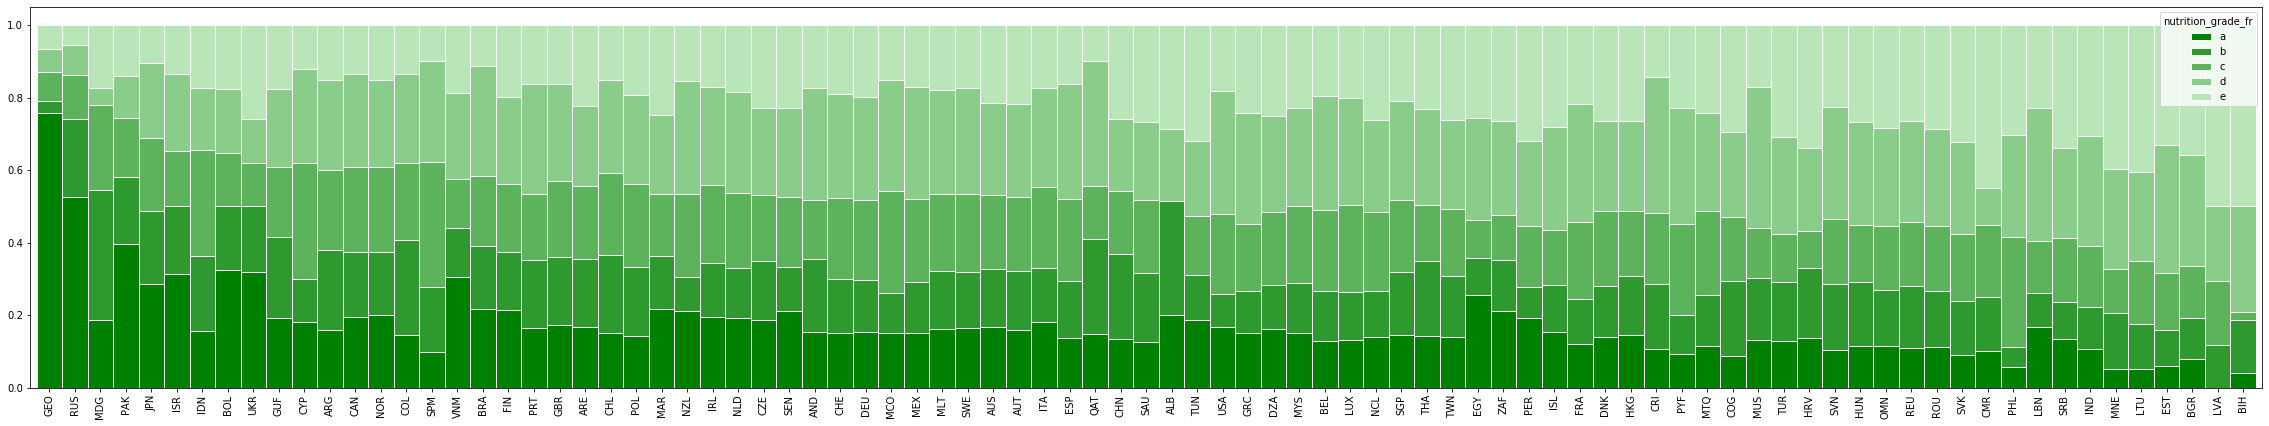

In [73]:
# build the ratios diagram, sorted from "desirable products" to "undesirable products"
pal = sns.light_palette("green", reverse=True)
sorted_percent_per_country.plot.bar(stacked=True, color=pal , figsize=(40,7), edgecolor='white', width=1);

In [74]:
# consider the desirable results are those with a nutri-score of 'a', 'b', and 'c'
ratio_of_desirable = pd.DataFrame({ 'ratio':sorted_percent_per_country['a']+sorted_percent_per_country['b']+sorted_percent_per_country['c'] })

# transforms the country index into an actual column
ratio_of_desirable = ratio_of_desirable.reset_index().rename(columns={'index':'country'})

# show the first few rows of sorted table by ratio of "desirable product" 
ratio_of_desirable.sort_values(by='ratio', ascending=False).head(10)

,country,ratio
0,GEO,0.870968
1,RUS,0.861439
2,MDG,0.779070
3,PAK,0.744186
4,JPN,0.688571
6,IDN,0.655172
5,ISR,0.652542
7,BOL,0.647059
15,SPM,0.622951
8,UKR,0.620000


## 5.3 Calculate correlation with life expectancy: "Is there a link between Nutri-score products in stores and life expectancy?"

We will now be combining the overall "shape" of the nutri-score data of products in each country with the information on life expectancy in the same countries and try to assess if there is any correlation among the 2 variables.

As a first step, let's visualise the life expectancy on a world map.

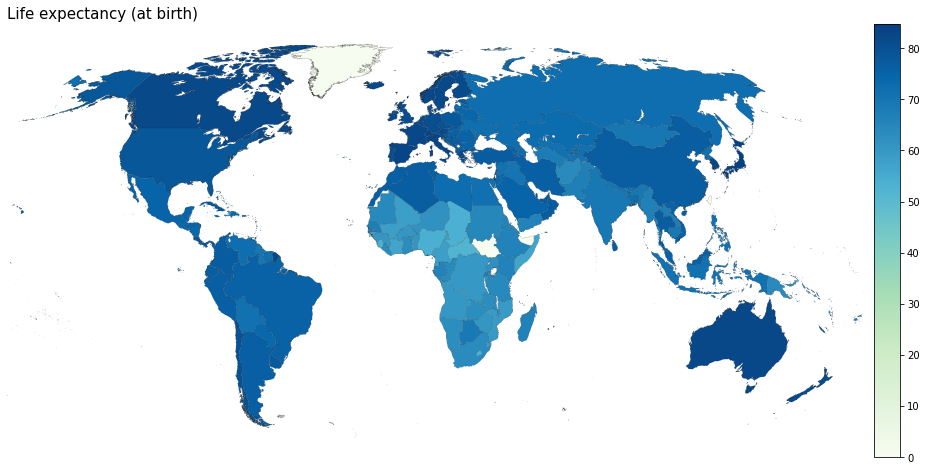

In [75]:
#Show the life expectancy on a map
mapdata = geomapping (gdf, expect_df, column='Country Code')
plot_map(mapdata, 'Life expectancy (at birth)', column='2017')

Then we will be calculating the correlation between the ratio of "desirable products" in the country and life expectancy

In [76]:
# Build a dataframe with only the 2 necessary columns: life expectancy at birth evaluated in 2017, and the ratio of "desirable products" sold in the country
df_corr = expect_df.merge(ratio_of_desirable, left_on='Country Code', right_on='country').loc[:,['2017','ratio']]
df_corr.columns=['life expectancy (at birth)','ratio of desirable products']

# print the shape of the respective dataframes
print('shape of expect_df: ', expect_df.shape)
print('shape of ratio_of_desirable: ', ratio_of_desirable.shape)
print('shape of df_corr: ', df_corr.shape)

# show the top rows of the data used to calculate the correlation
df_corr.sort_values(by='ratio of desirable products', ascending=False).head(10)

shape of expect_df:  (245, 3)
shape of ratio_of_desirable:  (87, 2)
shape of df_corr:  (80, 2)


,life expectancy (at birth),ratio of desirable products
29,73.414000,0.870968
65,72.119024,0.861439
46,66.311000,0.779070
57,66.947000,0.744186
40,84.099756,0.688571
34,71.282000,0.655172
38,82.602439,0.652542
8,70.945000,0.647059
76,71.780976,0.620000
18,80.672000,0.620000


In [77]:
# calculate the correlation (usually provided as a matrix) and select only a cell that gives the coefficient
df_corr.corr().iloc[0,1]

-0.03235390757240936

We will show the same result on a diagram.

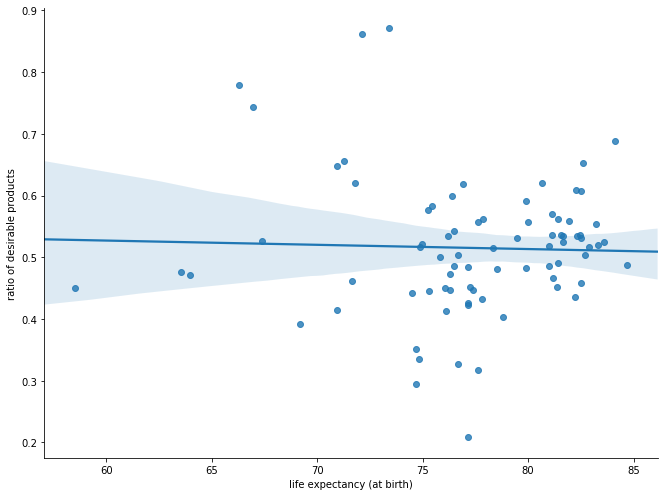

In [78]:
# plot the dots on a diagram and draw the linear regression line to visualise the correlation
sns.lmplot(x='life expectancy (at birth)',y='ratio of desirable products',data=df_corr,fit_reg=True, height=7, aspect=4/3) ;

There is no correlation between the ratio of products in category a,b,c ("desirable products") sold in the country and life expectancy. They seem to be independent variables.

# 6. Conclusion

You should always remember that correlation is not causation, and in our case since there is no correlation we could assume there is no causation.
The absence of correlation could however be due to:

- there could really be no correlation between the variables and whatever products you eat would not be correlated with life expectancy
- or it could be due to the fact the products sold today would not have an impact on life expectancy measured today. There is a delay and life expectancy today could be a result of the products sold in the past 30 years or more
- or the data collected from openfoodfacts being crowdourced and not having a lot of data points in many countries may not be sufficient or accurate enough to identify a correlation

Since we cannot be sure we determined a proper grouping of "desirable products" that we expected to favor a higher life expectancy, we will re-run the analysis with 2 different groupings. So far we have bundled nutri-score 'a', 'b', and 'c' together. In the next cells we will look at 2 other groupings.

In [79]:
# defining a function to be able to reproduce the analysis with different views of what a "good nutri-score" could mean
def assess_corr(df, expect_df):
    """Shows the scatter plot of the points and returns a correlation between a "good nutri-score" ratio of products sold and life expectancy per country 
    
    Arguments:
        df: 
        expect_df: 
    
    Returns:
        correlation r coefficient
    """
    ratio_of_desirable = pd.DataFrame(df)
    ratio_of_desirable = ratio_of_desirable.reset_index().rename(columns={'index':'country'})
    df_corr = expect_df.merge(ratio_of_desirable, left_on='Country Code', right_on='country').loc[:,['2017','ratio']]
    sns.lmplot(x='2017', y='ratio', data=df_corr, fit_reg=True, height=7, aspect=4/3);
    return df_corr.corr().iloc[0,1]

-0.1128259684496481

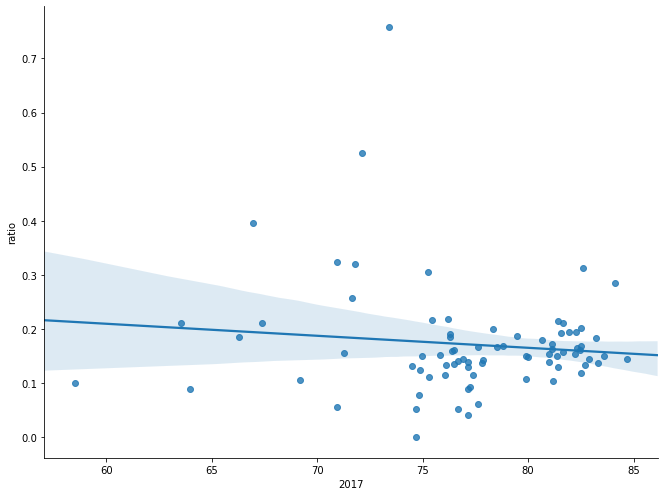

In [80]:
# perform the same processes as above, except with considering only nutri-score 'a' is the set of "desirable products"
assess_corr({ 'ratio': sorted_percent_per_country['a'] }, expect_df)

There is also no significative correlation when considering only nutri-score 'a' is the set of "desirable products"

-0.12347945967906043

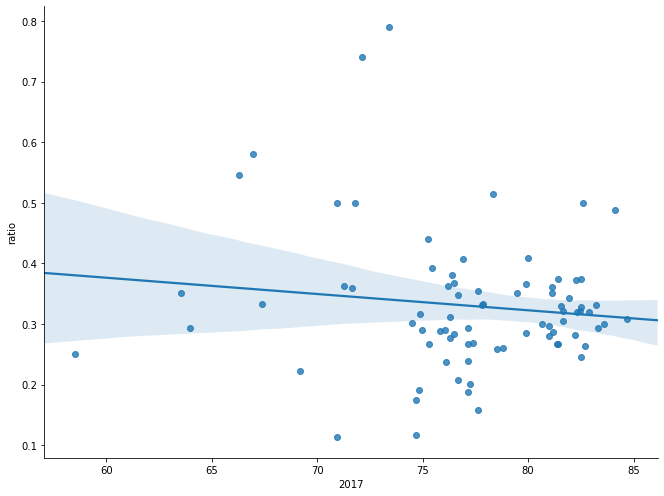

In [81]:
# perform the same processes as above, except with considering only nutri-scores 'a' and 'b' are the set of "desirable products"
assess_corr({ 'ratio': sorted_percent_per_country['a']+sorted_percent_per_country['b'] }, expect_df)

There is also no significative correlation when considering only nutri-scores 'a' and 'b' are the set of "desirable products"

The results are similar, and even seem to indicate a _very weak_ negative correlation which would mean that the more "desirable products" are available on the shelves of the stores, the lower the life expectancy in the respective country. This is a result difficult to believe and since the correlation is extremely weak the better conclusion is that we were not able to demonstrate a correlation.

My recommendation will therefore be to continue be careful about the labels of products you buy and live a healthy life!